# Machine Learning: Logistic Regression

## 0 Imports

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
warnings.filterwarnings("ignore")
from sklearn import linear_model
from sklearn.metrics import confusion_matrix, recall_score, matthews_corrcoef
from sklearn.model_selection import train_test_split, GridSearchCV

In [10]:
data = pd.read_csv("../dat/dips/DIPS_Data_cleaned.csv", sep = ",", low_memory = False)
data_change = pd.read_csv("../dat/dips/DIPS_Data_cleaned_change.csv", sep = ",", low_memory = False)
data_pred = pd.read_csv("../dat/dips/DIPS_Data_cleaned_pred.csv", sep = ",", low_memory = False)
data_pred_y = pd.read_csv("../dat/dips/DIPS_Data_cleaned_pred_y.csv", sep = ",", low_memory = False)

## 1 Logistic Regression Model

In [11]:
# Predictors
X = data_change
X = X.drop(["hpi"], axis = 1)

# Target
y = data_change["hpi"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

print("Logistic Regression \n",
      "X_train shape: ", X_train.shape, round(X_train.shape[0]/len(X), 2), "\n",
      "X_test shape: ", X_test.shape, round(X_test.shape[0]/len(X), 2),  "\n",
      "y_train shape: ", y_train.shape, round(y_train.shape[0]/len(y), 2), "\n",
      "y_test shape: ", y_test.shape, round(y_test.shape[0]/len(y), 2), "\n")

Logistic Regression 
 X_train shape:  (983, 22) 0.8 
 X_test shape:  (246, 22) 0.2 
 y_train shape:  (983,) 0.8 
 y_test shape:  (246,) 0.2 



In [12]:
def sklearn_log_regression(x_test_l, x_train_l, y_train_l, y_test_l):
    """Computes OLS weights for linear regression with lasso regularization using the sklearn library on the training set and
       returns weights, testset predictions and metrics.
    """
    # 1: GRID SEARCH
    log_model = linear_model.LogisticRegression(random_state = 42, solver = "saga")

    param_grid = {
        'C': [0.001, 0.01, 0.1, 1, 10],
        'penalty': ['l1', 'l2', 'elasticnet', None]
    }

    grid_search = GridSearchCV(estimator = log_model, param_grid = param_grid, cv = 10)
    grid_search.fit(x_train_l, y_train_l)
    best_model = grid_search.best_estimator_
    print("Best parameters: ", grid_search.best_params_)
    print("Best score: ", grid_search.best_score_)

    # 2: FITTING THE MODEL
    model = linear_model.LogisticRegression(C = best_model.C,
                                            penalty = best_model.penalty,
                                            solver = "saga",
                                            max_iter = 10000)
    model.fit(x_train_l, y_train_l)


    # 3: ESTIMATING WEIGHTS
    weights_l = model.coef_
    features_l = model.feature_names_in_

    # 4: COMPUTE TEST SET PREDICTIONS
    y_pred_l = model.predict(x_test_l)

    # 5: COMPUTE METRICS
    accuracy_l = model.score(x_test_l, y_test_l)
    macro_f1_l = recall_score(y_test_l, y_pred_l, average = "macro")
    micro_f1_l = recall_score(y_test_l, y_pred_l, average = "micro")
    mcc_l = matthews_corrcoef(y_test_l, y_pred_l)

    cm_l = confusion_matrix(y_test_l, y_pred_l)
    precision_l = cm_l[1][1] / (cm_l[1][1] + cm_l[0][1])
    recall_l = cm_l[1][1] / (cm_l[1][1] + cm_l[1][0])

    # store metrics in a dictionary
    metrics_l = {
        "accuracy": round(accuracy_l, 4),
        "macro_f1": round(macro_f1_l, 4),
        "micro_f1": round(micro_f1_l, 4),
        "mcc": round(mcc_l, 4),
        "precision": round(precision_l, 4),
        "recall": round(recall_l, 4),
        "confusion_matrix": cm_l
    }

    return weights_l, y_pred_l, features_l, metrics_l

In [13]:
start = time.time()

weights_lr, y_pred_lr, features_lr, metrics_lr = sklearn_log_regression(X_test, X_train, y_train, y_test)

end = time.time()
print("Execution time: ", {end - start}, "seconds")
time_lr = end - start
time_lr_df = pd.DataFrame({"time": [time_lr]})
time_lr_df.to_csv("../exp/times_ML/time_lr.csv", sep = ",", index = False)

# save weights and predictions
weights_lr_df = pd.DataFrame(weights_lr, columns = features_lr)
y_pred_lr = pd.DataFrame(y_pred_lr, columns = ["y_pred"])

weights_lr_df.to_csv("../exp/weights/weights_lr.csv", sep = ",", index = False)
y_pred_lr.to_csv("../exp/predictions/y_pred_lr.csv", sep = ",", index = False)

Best parameters:  {'C': 0.1, 'penalty': 'l1'}
Best score:  0.7344155844155844
Execution time:  {1.425757884979248} seconds


In [14]:
metrics_lr

{'accuracy': 0.7317,
 'macro_f1': 0.5571,
 'micro_f1': 0.7317,
 'mcc': np.float64(0.1922),
 'precision': np.float64(0.5789),
 'recall': np.float64(0.1594),
 'confusion_matrix': array([[169,   8],
        [ 58,  11]])}

In [15]:
# plot feature importance
def plot_feature_importance(weights, features, title):
    """Plot feature importance for linear regression model"""
    # get absolute value of weights
    weights = np.abs(weights)

    # create dataframe
    df = pd.DataFrame({"features": features, "weights": weights[0]})

    # sort by weights
    df = df.sort_values(by = "weights", ascending = False)

    # plot
    plt.figure(figsize = (10, 10))
    sns.barplot(x = "weights", y = "features", data = df)
    plt.title(title)
    plt.show()

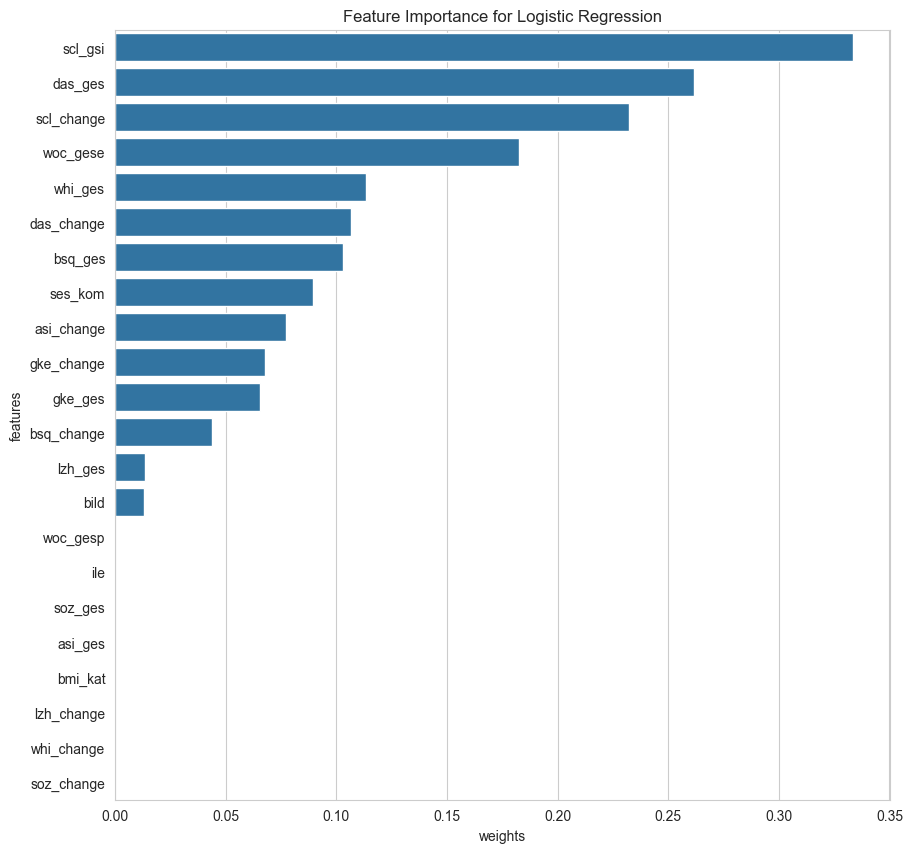

In [16]:
plot_feature_importance(weights_lr, features_lr, "Feature Importance for Logistic Regression")